In [1]:
# standard python utilities
import os
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [2]:

# run installed version of flopy or add local path
try:
    import flopy
    from flopy.discretization.structuredgrid import StructuredGrid
    from flopy.utils.reference import SpatialReference
    from flopy.utils import Raster
except:
    import flopy
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    from flopy.discretization.structuredgrid import StructuredGrid
    from flopy.utils.reference import SpatialReference
    from flopy.utils import Raster
from flopy.utils.gridgen import Gridgen
from flopy.utils import OptionBlock
import flopy.utils.binaryfile as bf


print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.21.2
matplotlib version: 3.5.0
flopy version: 3.3.4


In [3]:
from os.path import basename, dirname, exists
## Set up directory referencing
# Package data
usr_dir = os.getcwd()
while basename(usr_dir) !='Users':
    temp = basename(usr_dir)
    usr_dir = dirname(usr_dir)
usr_dir += '/'+temp
gwfm_dir = usr_dir+'/Box/research_cosumnes/GWFlowModel/'
dis_dir = gwfm_dir+'DIS_data/'
print(gwfm_dir)

C:\Users/ajcalder/Box/research_cosumnes/GWFlowModel/


In [4]:
# New model domain 52.9 deg
m_domain = gpd.read_file(dis_dir+'NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp')


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


In [290]:
xll, yll = list(m_domain.geometry.values[0].exterior.coords)[0]
#Maribeth's model parameters, had to switch nrow and ncol due to her issue in xul, yul
nrow=100
ncol=230
delr=np.repeat(200,ncol)
delc=np.repeat(200,nrow)
rotation=52.9
modelgrid = flopy.discretization.StructuredGrid(xoff=xll, yoff=yll, proj4='EPSG:32610', angrot=rotation,
                                   delr=delr, delc=delc, nrow=nrow,ncol=ncol)

### Crop coefficients and ETo

In [291]:

uzf_dir = gwfm_dir+'UZF_data/'

# crop_path = uzf_dir+'Newmodeldomain_cropdata_2007_2019'
crop_path = uzf_dir+'Modeldomain_cropdata_2007_2021'

crop_raster_names = glob.glob(crop_path+'/*.tif')
crop_dbf_names = glob.glob(crop_path+'/*.dbf')

import pathlib

crop_raster_list = list(pathlib.Path(crop_path).glob('*.tif'))
crop_dbf_list = list(pathlib.Path(crop_path).glob('*.dbf'))


In [292]:
# A-B, A-C, A-D are the percent of the season for each Kc
# The dates are the dates of the growing season
Kc = pd.read_csv(uzf_dir+'Kc/Kc_Current.csv',skiprows = 1)
Kc = Kc.rename(columns={'Unnamed: 0' : 'Match_kc'})

In [293]:
def crop_raster2array(raster_file_name, dbf_filename, Kc):
    # read in crop raster and database of crop values
    src = rasterio.open(raster_file_name)
    crop_dbf = pd.DataFrame(gpd.read_file(dbf_filename))
        
    band1 = src.read(1)
    band1 = band1.astype('int16')
    band1 = band1.astype(float)
    band3 = band1.reshape(1, band1.shape[0], band1.shape[1])[:,:,:]
    # turn the rasterio format into a flopy format
    # for some reason flopy will not directly read in the raster .tif
    croprio = Raster(band3, bands = (1,), crs = src.crs, transform = src.transform, 
                 nodataval = 255)
    # no longer need to crop as data from USDA was downloaded to fit domain
    # crop the raster to the model domain
#     croprio.crop(vertices, invert=False)
    
    # The original crop raster has a cell size of 56 by 56 m so if there are less than 4 cells of one crop
    # then for certain they will not fill one cell and most likely have minimal impact considering there are 
    # 6300 model cells in one layer
    crop_hist = np.histogram(band3, bins = np.arange(0,257))
    # only need to filter out those that have no cells in the domain
    crops_in_domain = crop_hist[1][:-1][crop_hist[0]>1]
#     crops_in_domain = crop_hist[1][:-1]
    
    domain_dbf = crop_dbf.iloc[crops_in_domain]

    domain_dbf['CLASS_NAME'] = domain_dbf.CLASS_NAME.str.replace('Dbl Crop ','')
    domain_dbf['crop_hist'] = crop_hist[0][crops_in_domain]
    # remove the 0/background value from the domain_dbf because it messes with the crop histogram
    domain_dbf = domain_dbf.drop(0)
    # then create a column with the percent of the crop
    domain_dbf['crop_percent'] = 100*domain_dbf.crop_hist/domain_dbf.crop_hist.sum()
    Kcmatch = pd.read_csv(uzf_dir+'Kc/Cosumnes_crops.csv', index_col = 0)

    # domain_dbf['crop1'] = domain_dbf.CLASS_NAME.str.split('/', expand = True)[0]
    # domain_dbf['crop2'] = domain_dbf.CLASS_NAME.str.split('/', expand = True)[1]

    domain_dbf = domain_dbf.merge(Kcmatch, on = 'CLASS_NAME')
    domain_dbf = domain_dbf.merge(Kc, left_on = 'Match_kc', right_on = 'Match_kc', how = 'left')
    return(croprio, domain_dbf)


In [294]:
# Original model domain, 44.7 deg angle
# m_domain = gpd.read_file(gwfm_dir+'/Archive\\GWModelDomain_UTM10N\\GWModelDomain_Rec_UTM10N.shp')
# New model domain 52.9 deg
# m_domain = gpd.read_file(gwfm_dir+'/DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp')

grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__ar

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Rainfall and ET data from CIMIS

In [295]:
## Before resampling to the grid, I need to convert from a crop label with integer format to
## a crop coefficient format that is a float that can be weighted by the number of cells

In [296]:

## Potential ETo spatial interpolation from CIMIS
fn = glob.glob(uzf_dir+'Cosumnes_dailyET_precip*.csv')
daily_data = pd.DataFrame()
for file in fn:
    new_data = pd.read_csv(file, index_col = ['Date'], parse_dates = True)
    daily_data = daily_data.append(new_data)
    
# sensor locations
coords = pd.read_csv(uzf_dir+'CIMIS_station_lat_long.csv', index_col = 0)
coords = gpd.GeoDataFrame(coords,geometry = gpd.points_from_xy(coords['Long'] ,coords['Lat']))
# Convert WGS Lat and long to Easting and Northing in Zone 10N
coords.crs = 'epsg:4326'
coords = coords.to_crs('epsg:32610')

# clean up data so columns are by location, units of ETo are in mm
ET = daily_data.pivot_table(index = 'Date', columns = ['Stn Id', 'Stn Name', 'CIMIS Region'], values = 'ETo (mm)')

# clean up data so columns are by location, units of Precip are in mm
rain = daily_data.pivot_table(index = 'Date', columns = ['Stn Id', 'Stn Name', 'CIMIS Region'], values = 'Precip (mm)')
# there are quite a few days missing rainfall at one station, could generally assume those are zero rain days

### Create monthly values of ET and rain

In [297]:
monthly_ET = ET.resample('M').sum()
monthly_rain = rain.resample('M').sum()

# Need to fix missing rainfall/ET data
temporary fix for now is to set any missing data to zero

Text(0, 0.5, 'Number of days with CIMIS data')

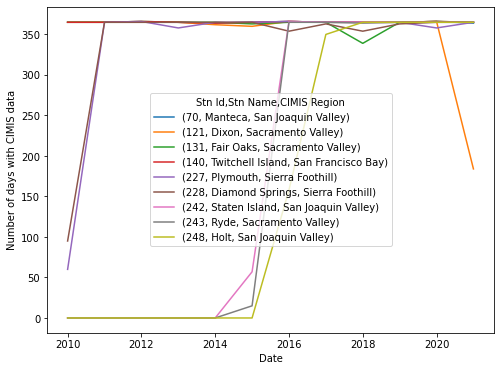

In [298]:
# rain.loc[rain.index > '2018-01-01'].iloc[34:40]
# Check on missing rain data, Ryde, Holt, and Staten Island aren't installed until 2015... need to find more stations
fig, ax = plt.subplots(figsize = (8,6))
rain.groupby(rain.index.year).count().plot(ax=ax)

plt.ylabel('Number of days with CIMIS data')
# plt.savefig('Plots/Model_SFR_UZF_progress/cimis_stations_data_availability.png', dpi = 600, bbox_inches='tight')

# Same situation for ET
# ET.groupby(rain.index.year).count().plot()

In [299]:
strt_date = rain.index.min()
end_date = rain.index.max()
print('Start Date:',strt_date,'End date:', end_date)
nrow = grid_p.row.max()
ncol = grid_p.column.max()

Start Date: 2010-01-01 00:00:00 End date: 2021-12-31 00:00:00


In [300]:
x_out = grid_p.geometry.centroid.x.values
y_out = grid_p.geometry.centroid.y.values


In [301]:

def gridded_interpolation_cimis(df, x_out=x_out, y_out=y_out):
    # dataframe is data from multiple cimis stations
    # that has been cleaned into multiple columns 
    # and sorted by date
    ncell = nrow*ncol

    # Filter climate data for the strt_date and end_date of the model stress periods
    spd = df.loc[strt_date:end_date]

    # Get the xy cell centers for the model grid
    out_xy = np.transpose(np.vstack((x_out, y_out)))

    # reshape the xy data
#     out_xy = np.transpose(np.vstack([np.reshape(xy[0:nrow], ncell),np.reshape(xy[nrow:],ncell)]))
#     out_xy.shape, xy.shape
    # out_xy

    from scipy.interpolate import griddata
    in_xy = np.transpose(np.vstack([coords.geometry.x.values, coords.geometry.y.values]))
    # Final reshaped array of interpolated ET
    final = np.zeros((len(spd), nrow, ncol))

    for i in np.arange(0,len(spd)):
        # scipy interpolation based on point locations
        notna_data = spd.iloc[i].notna().values
        grid = griddata(in_xy[notna_data], spd.iloc[i].loc[notna_data].values, xi = out_xy,
                        method = 'linear') # maybe try linear?
        # if interpolation fails fill, with other values
        if np.isnan(grid).sum() >0:
            grid_nearest = griddata(out_xy[~np.isnan(grid)], grid[~np.isnan(grid)], xi = out_xy,
                                method = 'nearest')
            grid[np.isnan(grid)] = grid_nearest[np.isnan(grid)]
        final[i,:,:] = np.reshape(grid, (nrow,ncol))
        
    return(final)


In [302]:
# interpolate between the CIMIS stations for gridded data via scipy.griddata
ET_final = gridded_interpolation_cimis(ET)
rain_final = gridded_interpolation_cimis(rain)
# calculate for monthly summed values
monthly_ET_final = gridded_interpolation_cimis(monthly_ET)
monthly_rain_final = gridded_interpolation_cimis(monthly_rain)

In [303]:
# convert from unis of mm to meters
ET_final = ET_final/1000
rain_final = rain_final/1000
monthly_ET_final = monthly_ET_final/1000
monthly_rain_final = monthly_rain_final/1000

rain_final.shape
# correct for any interpolated values that set rainfall or ETo to less than 0
ET_final[ET_final<0] = 0
rain_final[rain_final<0] = 0
monthly_ET_final[monthly_ET_final<0] = 0
monthly_rain_final[monthly_rain_final<0] = 0


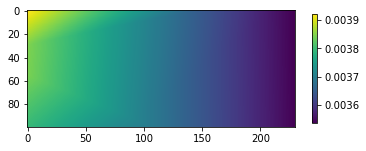

In [307]:
plt.imshow(np.mean(ET_final,axis=0))
plt.colorbar(shrink=0.5)

## Simplified ETo with just Fair Oaks

In [20]:
ET_fo = ET.loc[:,(131.0, 'Fair Oaks', 'Sacramento Valley')]
# convert from mm to meters
ET_fo = ET_fo/1000
temp = np.ones((len(ET_fo), nrow,ncol))
for t in np.arange(0,len(ET_fo)):
    temp[t,:,:] = ET_fo.values[t]
    
ET_fo = temp


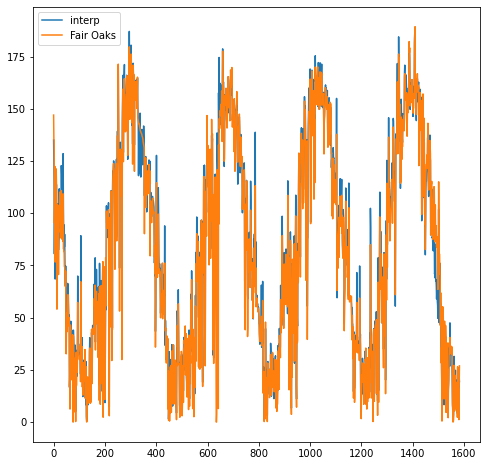

In [21]:
fig,ax=plt.subplots(figsize=(8,8))
plt.plot(ET_final[2800:,:,:].sum(axis=(1,2)),label = 'interp')
plt.plot(ET_fo[2800:,:,:].sum(axis=(1,2)),label = 'Fair Oaks')
plt.legend()

## Save rain and ET as arrays in text file format for easy model import

In [22]:
#pd.to_datetime(strt_date).year
for y in np.arange(pd.to_datetime(strt_date).year, pd.to_datetime(end_date).year+1):
    out_fn = uzf_dir+'Rain_all_txt_arrays/Rain_array_'+str(y)+'.tsv'
    # only create new arrays if they don't exist
    if exists(out_fn):
        print('Already exists')
    elif not exists(out_fn):
        # set start and end date for range for the year to be iterated over
        yr_strt = pd.to_datetime(str(y)+'-01-01')
        yr_end = pd.to_datetime(str(y)+'-12-31')
        if yr_strt < pd.to_datetime(strt_date):
            yr_strt = pd.to_datetime(strt_date)
        if yr_end > pd.to_datetime(end_date):
            yr_end = pd.to_datetime(end_date)
        # start index based on difference from start year and current year
        rain_index = (yr_strt-pd.to_datetime(strt_date)).days
        yearlen = len(pd.date_range(yr_strt, yr_end))
        # calculate the ETc for the year and then save to a text file
        year_rain = np.zeros((yearlen,rain_final.shape[1],rain_final.shape[2]))
        year_rain[:,:,:] = rain_final[rain_index:rain_index+yearlen]
        reshaped_rain = np.reshape(year_rain, (year_rain.shape[0]*nrow, ncol))
        revert_rain = np.reshape(reshaped_rain, (year_rain.shape[0], nrow, ncol))
        print('Rehaping ETc and revert sum/check = ', (year_rain-revert_rain).sum())
        np.savetxt(out_fn , reshaped_rain,  delimiter = '\t')


Already exists
Already exists
Already exists
Already exists
Already exists
Already exists
Already exists
Already exists
Already exists
Already exists
Already exists
Already exists


The rain export to arrays works well, just need to check that the gridded_data matches the point data

1038


<AxesSubplot:>

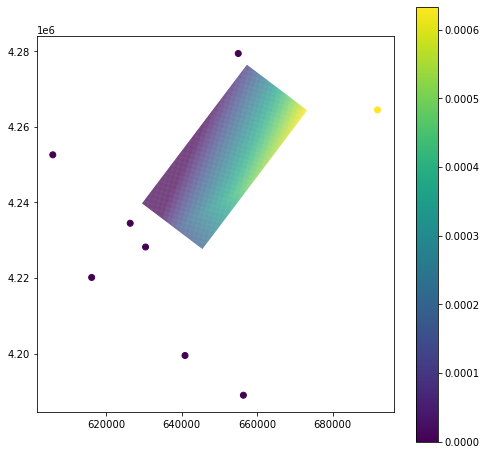

In [23]:
# find where substantial rain happens
where_rain = np.where(rain.mean(axis=1)>0.1)[0]
print(len(where_rain))
i = where_rain[800]

coords_plot = coords.copy()
coords_plot['rain_m'] = rain.iloc[i].values

fig, ax = plt.subplots(figsize=(8,8))
grid_p['rain_m'] = np.reshape(rain_final[i], nrow*ncol)
grid_p.plot('rain_m', ax=ax, legend = True)
coords_plot.plot('rain_m', ax=ax)

In [308]:
def calc_kc_dates(year, domain_dbf):
    # The year for each crop for each set of dates needs to change iteratively for each crop individually because
    # some crops have dates that extend into the next year that must not change until the final date of the 
    # season is reached (e.g. 2018-11-01 to 2019-09-17 must stay 2018 and 2019 until 2019-09-17 is reached)
#     i = 2018
    dates = domain_dbf.loc[:,['Beg Month','Beg Day', 'End Month', 'End Day', 'A-B', 'A-C', 'A-D']]

    # Set the pandas datetime from the start and end dates of crops
    # need to just takes .values or indexing will be wrong and mismatch dates to rows
    dates['A'] = pd.to_datetime({'year': year, 'month':dates['Beg Month'].values, 'day': dates['Beg Day'].values}).values
    dates['E'] = pd.to_datetime({'year': year, 'month':dates['End Month'].values, 'day': dates['End Day'].values}).values
    # Make correction for any end dates that are in the next year
    dates.E.loc[dates.E < dates.A] = dates.E.loc[dates.E < dates.A] + pd.offsets.DateOffset(years=1)

    # Get the length of the growing periods
    dates['num_days'] = dates.E-dates.A

    # set the end date of growing period A/ start of period B
    dates['B'] = dates.A + dates.num_days*(dates['A-B']/100)
    # Round the dates, as we will be one a daily time step
    dates.B = pd.to_datetime(dates.B.dt.date)

    # # set the end date of growing period B/ start of period C
    dates['C'] = dates.B + dates.num_days*((dates['A-C']-dates['A-B'])/100)

    # # set the end date of growing period C/ start of period D
    dates['D'] = dates.C + dates.num_days*((dates['A-D']-dates['A-C'])/100)
    return(dates)

In [309]:
def ETc_calc(ET_final, dates, domain_dbf):
    ETc = np.zeros((yearlen,nrow,ncol))
    Kc_arr = np.zeros((yearlen,nrow,ncol))

    time = 0
    for dt in pd.date_range(yr_strt, yr_end):
        # First step is to get the current Kc for each crop for the time step
        domain_dbf.Kc.loc[dt > dates.A] = domain_dbf.loc[dt > dates.A, 'Kc1']
        domain_dbf.Kc.loc[dt > dates.B] = domain_dbf.loc[dt > dates.B, 'Kc2']
        domain_dbf.Kc.loc[dt > dates.C] = domain_dbf.loc[dt > dates.C, 'Kc3']
        domain_dbf.Kc.loc[dt > dates.D] = domain_dbf.loc[dt > dates.D, 'Kc4']
        domain_dbf.Kc.loc[dt > dates.E] = domain_dbf.loc[dt > dates.E, 'Kc4']
        for i,j in zip(domain_dbf.index.values, domain_dbf.Kc.values):
            Kc_arr[time,crop_data==i] = j
        ETc[time,:,:] = Kc_arr[time,:,:]*ET_final[time,:,:]
        time += 1
    return(ETc, Kc_arr)

In [15]:
strt_date = rain.index.min()
end_date = rain.index.max()

In [56]:

# iterate over each year and calculate Kc with crop coefficients
for y in np.arange(pd.to_datetime(strt_date).year, pd.to_datetime(end_date).year+1):
    fn_r = glob.glob(crop_path+'/CDL_'+str(y)+'*.tif')[0]
    fn_d = glob.glob(crop_path+'/CDL_'+str(y)+'*.dbf')[0]

    out_fn = uzf_dir+'ETa_all_txt_arrays/ETa_array_'+str(y)+'.tsv'
    # only create new arrays if they don't exist
    if exists(out_fn):
        print('Already exists')
    elif not exists(out_fn):
        # set start and end date for range for the year to be iterated over
        yr_strt = pd.to_datetime(str(y)+'-01-01')
        yr_end = pd.to_datetime(str(y)+'-12-31')
        if yr_strt < pd.to_datetime(strt_date):
            yr_strt = pd.to_datetime(strt_date)
        if yr_end > pd.to_datetime(end_date):
            yr_end = pd.to_datetime(end_date)


        # for each year, import the new crop raster and resample to the model grid
        # and filter out the database of crops to match those in the domain
        croprio, domain_dbf = crop_raster2array(fn_r, fn_d, Kc)
        file_num +=1

#         crop_data = croprio.resample_to_grid(modelgrid,
#                                     band=croprio.bands[0], method="nearest")
        crop_data = croprio.resample_to_grid(modelgrid,
                                    band=croprio.bands[0], method="nearest")
        # adjust domain_dbf to account for resampling
        resampled_crops = np.append(np.unique(crop_data).astype(int),np.unique(crop_data)[-1])
        resampled_hist =  np.histogram(crop_data, bins = resampled_crops)
        # convert histogram to dataframe to join with domain database info for crops
        resampled_hist = pd.DataFrame(np.transpose(np.vstack((resampled_hist[0], resampled_hist[1][:-1]))))
        resampled_hist.columns =  ['crop_hist','VALUE']
        resampled_hist.VALUE = resampled_hist.VALUE.astype(int)

        resampled_df = resampled_hist.set_index('VALUE').join(domain_dbf.drop('crop_hist', axis=1).set_index('VALUE') , on = 'VALUE', how = 'inner')
        resampled_df.crop_percent = 100*resampled_df.crop_hist/resampled_df.crop_hist.sum()
        resampled_df['Kc'] = 0

        # calculate the Kc date periods for each year
        dates = calc_kc_dates(y, domain_dbf = resampled_df)

        # find length of each year for referencing for the ET_final whole period to individual years
        yearlen = len(pd.date_range(yr_strt, yr_end))

        # calculate the ETc for the year and then save to a text file
    #     ETc = ETc_calc(ET_final = ET_final[ET_index:ET_index+yearlen], dates=dates, domain_dbf= resampled_df)
    #     ETc = ETc_calc(ET_final = monthly_ET_final[ET_index:ET_index+yearlen], dates=dates, domain_dbf= resampled_df)
        # start index based on difference from start year and current year
        ET_index = (yr_strt-pd.to_datetime(strt_date)).days
        # alternative ET data set that uses only data from fair oaks
        ETc, Kc_arr = ETc_calc(ET_final = ET_fo[ET_index:ET_index+yearlen], dates=dates, domain_dbf= resampled_df)
#         ET_index += yearlen
        reshapedETc = np.reshape(ETc, (yearlen*nrow, ncol))
        revertETc = np.reshape(reshapedETc, (yearlen, nrow, ncol))
        print('Reshaping ETc and revert sum/check = ', (ETc-revertETc).sum())
        np.savetxt(out_fn, reshapedETc,  delimiter = '\t')

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

Reshaping ETc and revert sum/check =  0.0


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

Reshaping ETc and revert sum/check =  0.0


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

Reshaping ETc and revert sum/check =  0.0


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

Reshaping ETc and revert sum/check =  0.0


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

Reshaping ETc and revert sum/check =  0.0


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

Reshaping ETc and revert sum/check =  0.0


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

Reshaping ETc and revert sum/check =  0.0


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

Reshaping ETc and revert sum/check =  0.0


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

Reshaping ETc and revert sum/check =  0.0


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

Reshaping ETc and revert sum/check =  0.0


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

Reshaping ETc and revert sum/check =  0.0


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

Reshaping ETc and revert sum/check =  0.0


4359


<AxesSubplot:>

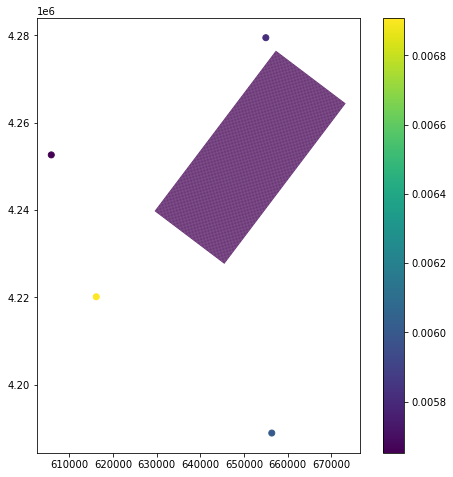

In [107]:
# find where substantial rain happens
where_ET = np.where(ET.mean(axis=1)>0.1)[0]
print(len(where_ET))
i = where_ET[200]

coords_plot = coords.copy()
coords_plot['ET_m'] = ET.iloc[i].values

fig, ax = plt.subplots(figsize=(8,8))
# grid_p['ET_m'] = np.reshape(ET_final[i], nrow*ncol)
grid_p['ET_m'] = np.reshape(ET_fo[i], nrow*ncol)
grid_p.plot('ET_m', ax=ax, legend = True)
coords_plot.plot('ET_m', ax=ax)

In [238]:
rain_final.shape, ET_final.shape, ETc.shape

((3652, 100, 230), (3652, 100, 230), (3652, 100, 230))

In [83]:
test2010 = np.loadtxt(gwfm_dir+'/UZF_data/ETa_all_txt_arrays/ETa_array_'+str(2018)+'.tsv', delimiter = '\t')
test2019 = np.loadtxt(gwfm_dir+'/UZF_data/ETa_all_txt_arrays/ETa_array_'+str(2020)+'.tsv', delimiter = '\t')

In [84]:
test2010.shape, test2019.shape

((36500, 230), (36600, 230))

In [85]:
yr_strt = pd.to_datetime(str(2010)+'-01-01')
yr_end = pd.to_datetime(str(2010)+'-12-31')
yearlen = len(pd.date_range(yr_strt, yr_end))
revert2010 = np.reshape(test2010, (yearlen, nrow, ncol))

yr_strt = pd.to_datetime(str(2020)+'-01-01')
yr_end = pd.to_datetime(str(2020)+'-12-31')
yearlen = len(pd.date_range(yr_strt, yr_end))
revert2019 = np.reshape(test2019, (yearlen, nrow, ncol))


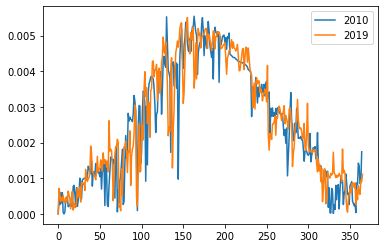

In [86]:
plt.plot(revert2010.mean(axis=(1,2)), label = '2010')
plt.plot(revert2019.mean(axis=(1,2)), label = '2019')
plt.legend()

## Determining locations of ag land for logical array and plotting
Create an output array for each year of estimated land use. This will then be read in to the model before creating the well package to determine which cells should estimate groundwater pumping based on applied water (ETc).
This could be further improved by looking at the EWRIMS (water rights) system to determine which sites are surafce water irrigated. These maps are adjusted based on the location of agricultural pumps to validate their definition as groundwater pumping.

In [16]:
def get_ag_land(crop_data,domain_dbf):
    ''' create boolean array of agricultural land based on USDA map and crop types'''
    ag_land_arr = np.ones(crop_data.shape)
    non_ag_land = ['Grassland/Pasture', 'Woody Wetlands','Herbaceous Wetlands', 'Open Water', 'Developed/Open Space',
                   'Developed/Low Intensity',  'Developed/Med Intensity', 'Developed/High Intensity', 'Barren',
                   'Fallow/Idle Cropland','Deciduous Forest', 'Evergreen Forest', 'Mixed Forest', 'Shrubland']
    # filter domain crop for developed land
    non_ag_land = domain_dbf.set_index('CLASS_NAME').filter(items =non_ag_land, axis=0)
    # find where in the crop array the pasture land is and set to 0
    for n in np.arange(0,len(non_ag_land)):
        ag_land_arr[crop_data==non_ag_land.VALUE.values[n]] = 0
    return(ag_land_arr.astype(bool))

def get_pasture_ag(crop_data, domain_dbf, pasture_ag_land):
    ''' Join array of Grassland/Pasture with location of radius of Ag wells
    to approximate pasture that is irrigated'''
    pasture_ag_land_arr = np.zeros((nrow,ncol)).astype(bool)
    pasture_ag_land_arr[pasture_ag_land.row-1,pasture_ag_land.column-1] = True
    pasture_val = domain_dbf[domain_dbf.CLASS_NAME=='Grassland/Pasture'].VALUE.values
    pasture_ag_land_arr = pasture_ag_land_arr & (crop_data==pasture_val)
    return(pasture_ag_land_arr)

def get_developed_land(crop_data, domain_dbf):
    ''' Map developed land (ie less infiltration)'''
    land_arr = np.zeros((nrow,ncol)).astype(bool)
    land_types = ['Developed/Low Intensity',  'Developed/Med Intensity', 'Developed/High Intensity']
    non_ag_land = domain_dbf.set_index('CLASS_NAME').filter(items =land_types, axis=0)
    # find where in the crop array the pasture land is and set to 0
    for n in np.arange(0,len(non_ag_land)):
        land_arr[crop_data==non_ag_land.VALUE.values[n]] = True
    return(land_arr)

In [17]:
wells = pd.read_csv(gwfm_dir+'/WEL_data/all_wells_type.csv', dtype = {'default':object})
wells_grid = gpd.GeoDataFrame(wells, geometry = gpd.points_from_xy(wells.easting,wells.northing), 
                              crs = 'epsg:32610')
well_strt_date = '2015-10-01'
wells_grid.DateWorkEnded = pd.to_datetime(wells_grid.DateWorkEnded )
wells_grid['well_age_days'] = (pd.to_datetime(well_strt_date) - wells_grid.DateWorkEnded).dt.days

# if wells_grid.row.min()==1:
wells_grid.row = (wells_grid.row-1).astype(int)
wells_grid.column = (wells_grid.column -1).astype(int)

In [18]:
wells_grid_ag = wells_grid.copy()
wells_grid_ag = wells_grid.loc[wells_grid.Simple_type == 'irrigation'].dissolve('node', aggfunc = 'mean')
wells_grid_ag.geometry = wells_grid.loc[wells_grid.Simple_type == 'irrigation'].dissolve('node', aggfunc = 'first').geometry

# remove wells younger than start of model
# remove wells older than 60 years for ag, think of Teichert wells from 60s (domestic wells age out earlier)
print(wells_grid_ag.well_age_days.notna().sum(), wells_grid_ag.shape, (wells_grid_ag.well_age_days > 60*365).sum())
wells_grid_ag = wells_grid_ag[wells_grid_ag.well_age_days < 60*365]

# the longest road on Teichert is 1500 m, and on a regional scale these seem to be the largest ag fields.
# Visually a 500 m buffer results in a small amount of ag, 1000 m causes near total coverage in upper basin
ag_wells_buffer = wells_grid_ag.loc[:,['well_age_days','geometry']]
ag_wells_buffer.geometry = ag_wells_buffer.geometry.buffer(1500)
pasture_ag_land = gpd.sjoin(grid_p, ag_wells_buffer, op='within')

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

280 (280, 14) 45


In [239]:
domain_dbf

,VALUE,RED,GREEN,BLUE,CLASS_NAME,OPACITY,geometry,crop_hist,crop_percent,Match_kc,...,End Day,Kc1,Kc2,Kc3,Kc4,A-B,A-C,A-D,type,group_name
0,1,1.000,0.827,0.000,Corn,1.0,None,15079,1.475116,Corn_field,...,17.0,0.20,1.05,1.05,0.60,20.0,45.0,75.0,Annual,<1% total area crops
1,2,1.000,0.149,0.149,Cotton,1.0,None,56,0.005478,Cotton,...,18.0,0.35,0.95,0.95,0.50,15.0,25.0,85.0,NaN,NaN
2,3,0.000,0.659,0.894,Rice,1.0,None,6081,0.594879,Rice_upland,...,17.0,1.10,1.00,1.00,0.60,18.0,24.0,78.0,Annual,Field Crops
3,4,1.000,0.620,0.043,Sorghum,1.0,None,18,0.001761,Grain_Sorghum,...,17.0,0.20,1.05,1.05,0.50,16.0,42.0,75.0,Annual,Field Crops
4,6,1.000,1.000,0.000,Sunflower,1.0,None,783,0.076598,Sunflower,...,15.0,0.20,1.10,1.10,0.40,20.0,45.0,80.0,Annual,Field Crops
5,13,0.867,0.647,0.043,Pop or Orn Corn,1.0,None,116,0.011348,Corn_grain,...,17.0,0.20,1.05,1.05,0.60,20.0,45.0,75.0,Annual,Field Crops
6,21,0.886,0.000,0.486,Barley,1.0,None,1670,0.163369,Barley,...,30.0,0.70,1.05,1.05,0.15,20.0,45.0,75.0,Annual,Grain
7,24,0.647,0.439,0.000,Winter Wheat,1.0,None,15882,1.553670,Wheat_winter,...,31.0,0.33,1.05,1.05,0.15,13.0,40.0,80.0,Annual,<1% total area crops
8,27,0.675,0.000,0.486,Rye,1.0,None,336,0.032869,Pasture_Rye,...,31.0,0.95,0.95,0.95,0.95,11.0,22.0,92.0,Annual,Grain
9,28,0.627,0.349,0.537,Oats,1.0,None,7626,0.746020,Oats,...,31.0,0.33,1.05,1.05,0.15,20.0,45.0,75.0,Annual,Grain


In [351]:
def plt_crops(crop_data, domain_dbf,ax, grouped = False, cb = False, **kwds):
    '''Create raster map of major crop types'''

    temp = np.zeros(crop_data.shape)
    domain_dbf.loc[domain_dbf.crop_percent<1,'group_name'] = '<1% total area crops'
#     main_crops = domain_dbf.loc[domain_dbf.crop_percent>1]
    main_crops = domain_dbf.copy()
    # create array to plot relevant values by crop or group
    if grouped == False: 
        nams = main_crops.CLASS_NAME.values
        vals = main_crops.VALUE.values
        for n, v in enumerate(vals):
            temp[np.isin(crop_data, v)] = n
    elif grouped == True:
        nams = main_crops.group_name.unique()
        for n, v in enumerate(nams):
            print(n+1,v)
            grp_crops = main_crops[main_crops.group_name == v].VALUE.values
            temp[np.isin(crop_data, grp_crops)] = n+1
#     print(nams)
    print(np.unique(temp))
#     labels = np.hstack(('<1% crop', nams))
    labels = np.hstack(('NaN', nams))
#     labels = nams
#     labels = np.flip(nams)
#     if 'cmap' not in locals():
    cmap = plt.cm.terrain  # define the colormap
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, len(labels))
    # define the bins and normalize
    bounds = np.append(np.unique(temp),np.max(temp)+1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
#     cmap = mpl.cm.get_cmap('terrain', len(labels))    # viridis is hard to distinguish, terrain
    ax.imshow(temp,cmap=cmap,  norm = norm)
    if cb == True:
#         print(temp.max)
        cbar = plt.colorbar(mappable = ax.images[0], spacing='uniform',
                           ticks=bounds[:-1]+0.5, boundaries = bounds, shrink = 0.5)
#         labels = nams
        cbar =cbar.ax.set_yticklabels(labels)
#         print(cbar.boundaries, cbar.values)


In [335]:
cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(len(labels))]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)
# create the new map


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1 Field Crops
2 <1% total area crops
3 Grain
4 Alfalfa/Other Hay
5 Natural
6 Fallow
7 Grapes
8 Nut Tree
9 Developed
10 Grassland/Pasture
11 Wetlands
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]


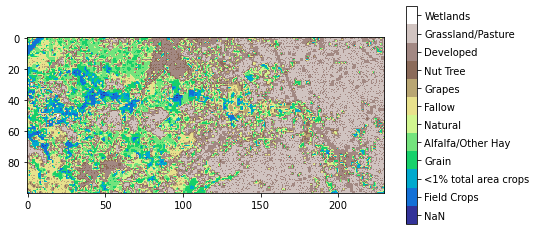

In [352]:
# for n,y in enumerate(np.arange(pd.to_datetime('2010-10-01').year, pd.to_datetime('2011-09-30').year+1)):
#     print(y)
y=2010
fn_r = glob.glob(crop_path+'/CDL_'+str(y)+'*.tif')[0]
fn_d = glob.glob(crop_path+'/CDL_'+str(y)+'*.dbf')[0]
croprio, domain_dbf = crop_raster2array(fn_r, fn_d, Kc)
# split crops in perennial and non-perennial
crop_grps = pd.read_csv(uzf_dir+'crop_groups.csv')
# join dbf with grouping names
domain_dbf = domain_dbf.join(crop_grps.set_index('CLASS_NAME'),on='CLASS_NAME')
    
crop_data = croprio.resample_to_grid(modelgrid,
                        band=croprio.bands[0],
                        method="nearest")

fig,ax=plt.subplots(figsize=(8,8))
plt_crops(crop_data, domain_dbf, ax, grouped=True, cb=True)


In [355]:
domain_dbf[domain_dbf.group_name=='Wetlands']
domain_dbf[domain_dbf.CLASS_NAME=='Woody Wetlands']

,VALUE,RED,GREEN,BLUE,CLASS_NAME,OPACITY,geometry,crop_hist,crop_percent,Match_kc,...,End Day,Kc1,Kc2,Kc3,Kc4,A-B,A-C,A-D,type,group_name
39,190,0.494,0.694,0.694,Woody Wetlands,1.0,None,6775,0.662774,"Trees,_Shrubs,_Other_Watercourse_Veg.",...,31.0,0.8,1.2,1.2,0.8,25.0,50.0,75.0,Natural,<1% total area crops


In [191]:

grp_crops = domain_dbf[domain_dbf.group_name == domain_dbf.group_name.unique()[0]].VALUE.values
crop_data [np.isin(crop_data, grp_crops)] = n

In [197]:

# domain_dbf = domain_dbf.drop(columns=['group_name','type'])
# np.sort(domain_dbf.CLASS_NAME.unique())

In [ ]:
# should filter flooding to locations within 3000 meters of the Cosumnes River and 
# 3000 meters (15 cells) of the model east boundary

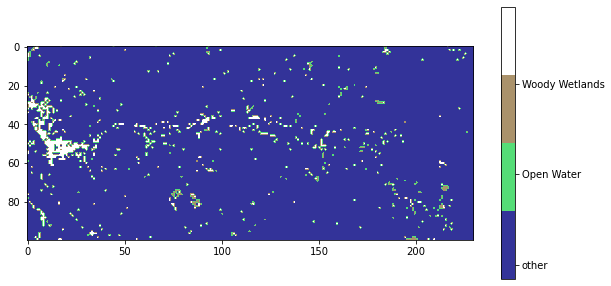

In [162]:
# Mixed Forest, Evergreen Forest, Deciduous Forest, Barren, Alfalfa, Other Hay/Non Alfalfa, Fallow/Idle Cropland
 # 'Shrubland' - too muchin foothills
flood_natl_lands = np.asarray(['Herbaceous Wetlands','Woody Wetlands','Open Water'] )
flood_ag_lands = np.asarray(['Alfalfa', 'Other Hay/Non Alfalfa', 'Fallow/Idle Cropland']) 
#'Mixed Forest', 'Evergreen Forest', 'Deciduous Forest', 'Barren', small compared to rest
              
flood_lands = np.append(flood_lands, potential_lands)

flood_natl_crops = domain_dbf[domain_dbf.CLASS_NAME.isin(flood_natl_lands)]
flood_ag_crops = domain_dbf[domain_dbf.CLASS_NAME.isin(flood_ag_lands)]
flood_crops = flood_natl_crops#.append(flood_ag_crops)

fig,ax=plt.subplots(figsize=(10,10))
temp = np.zeros(crop_data.shape)

for n in flood_crops.VALUE.values:
    temp[crop_data==n] = n
# plt.figure(figsize=(6,6))
cmap = mpl.cm.get_cmap('terrain', len(flood_crops.VALUE.values)+1)    # viridis is hard to distinguish
ax.imshow(temp,cmap=cmap)
# plt_crops(crop_data, domain_dbf, ax, cmap=cmap)
# crop_colorbar(ax,main_crops = flood_crops)
cbar = plt.colorbar(mappable = ax.images[0], 
                   ticks=np.linspace(10,flood_crops.VALUE.max()+10,len(flood_crops.VALUE.values)+1), shrink = 0.5)
labels = np.hstack(('other',flood_crops.CLASS_NAME.values))
cbar =cbar.ax.set_yticklabels(labels)

2010


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


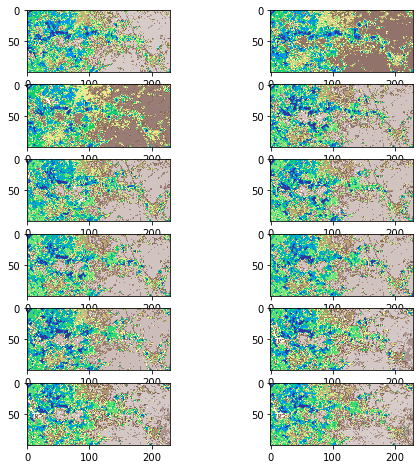

In [121]:
plt_col = 2
plt_row = int(12/plt_col)
fig,ax = plt.subplots(plt_row, plt_col, figsize=(8,8))

# for n in np.arange(0,len(crop_raster_list)):
for n,y in enumerate(np.arange(pd.to_datetime('2010-10-01').year, pd.to_datetime('2021-09-30').year+1)):
    print(y)
    fn_r = glob.glob(crop_path+'/CDL_'+str(y)+'*.tif')[0]
    fn_d = glob.glob(crop_path+'/CDL_'+str(y)+'*.dbf')[0]
    croprio, domain_dbf = crop_raster2array(fn_r, fn_d, Kc)
    crop_data = croprio.resample_to_grid(modelgrid,
                                band=croprio.bands[0],
                                method="nearest")
    temp = np.histogram(crop_data, bins = np.unique(crop_data))
    if n == 0:
        main_crops = domain_dbf.loc[domain_dbf.crop_percent>1]
        cmap = mpl.cm.get_cmap('terrain', len(main_crops.VALUE.values))    # viridis is hard to distinguish
#         crop_colorbar(ax[int(n / plt_col), n % plt_col], main_crops)
    plt_crops(crop_data, domain_dbf,ax[int(n / plt_col), n % plt_col], cmap=cmap)
    ag_land_arr = get_ag_land(crop_data, domain_dbf)
    pasture_ag_arr = get_pasture_ag(crop_data, domain_dbf, pasture_ag_land)
    all_ag_arr = ag_land_arr+pasture_ag_arr
    np.savetxt( gwfm_dir+'/WEL_data/simple_landuse_arrays/ag_land_'+str(y)+'.tsv', all_ag_arr,  delimiter='\t')
    urban_arr = get_developed_land(crop_data, domain_dbf)
    np.savetxt( gwfm_dir+'/WEL_data/simple_landuse_arrays/developed_land_'+str(y)+'.tsv', urban_arr,  delimiter='\t')

    
    flood_natl_arr = np.zeros(crop_data.shape)
    flood_ag_arr = np.zeros(crop_data.shape)

    for c in flood_natl_crops.VALUE.values:
        flood_natl_arr[crop_data==c] = c
    for c in flood_ag_crops.VALUE.values:
        flood_ag_arr[crop_data==c] = c
        
    np.savetxt(gwfm_dir+'/WEL_data/simple_landuse_arrays/natl_flood_land_'+str(y)+'.tsv', flood_natl_arr, delimiter='\t')
    np.savetxt(gwfm_dir+'/WEL_data/simple_landuse_arrays/ag_flood_land_'+str(y)+'.tsv', flood_ag_arr, delimiter='\t')

## Plot floodplain like lands

2010


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To

2011


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


2012


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


2013


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


2014


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


2015


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


2016


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


2017


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


2018


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


2019


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


2020


IndexError: index 11 is out of bounds for axis 0 with size 11

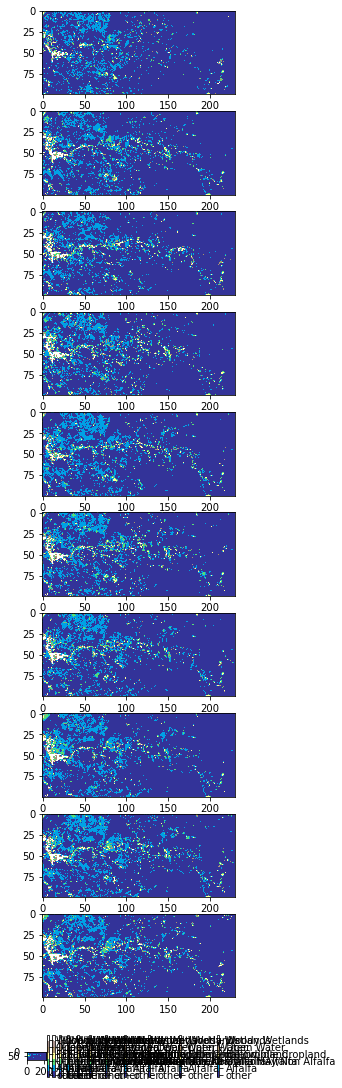

In [118]:
fig,axt=plt.subplots(11,1,figsize=(4,20))
for n,y in enumerate(np.arange(pd.to_datetime('2010-10-01').year, pd.to_datetime('2021-09-30').year+1)):
    ax = axt[n]
    print(y)
    fn_r = glob.glob(crop_path+'/CDL_'+str(y)+'*.tif')[0]
    fn_d = glob.glob(crop_path+'/CDL_'+str(y)+'*.dbf')[0]
    croprio, domain_dbf = crop_raster2array(fn_r, fn_d, Kc)
    crop_data = croprio.resample_to_grid(modelgrid,
                                band=croprio.bands[0],
                                method="nearest")
#     temp = np.histogram(crop_data, bins = np.unique(crop_data))
    
    temp = np.zeros(crop_data.shape)

    for n in flood_crops.VALUE.values:
        temp[crop_data==n] = n
    # plt.figure(figsize=(6,6))
#     cmap = mpl.cm.get_cmap('terrain', len(flood_crops.VALUE.values)+1)    # viridis is hard to distinguish
#     ax.imshow(temp,cmap=cmap)
#     # plt_crops(crop_data, domain_dbf, ax, cmap=cmap)
#     # crop_colorbar(ax,main_crops = flood_crops)
#     cbar = plt.colorbar(mappable = ax.images[0], 
#                        ticks=np.linspace(10,flood_crops.VALUE.max()+10,len(flood_crops.VALUE.values)+1), shrink = 0.5)
#     labels = np.hstack(('other',flood_crops.CLASS_NAME.values))
#     cbar =cbar.ax.set_yticklabels(labels)


# Crop histogram bar plot

In [23]:
# find the unique crop values in the resampled array and add one value at the end for the
# histogram that groups from first value to less than the next value except for the last
# number which includes both (e.g. [1,2), [2,3) [3,3]])
resampled_crops = np.append(np.unique(crop_data).astype(int),np.unique(crop_data)[-1])
resampled_hist =  np.histogram(crop_data, bins = resampled_crops)
# convert histogram to dataframe to join with domain database info for crops
resampled_hist = pd.DataFrame(np.transpose(np.vstack((resampled_hist[0], resampled_hist[1][:-1]))))
resampled_hist.columns =  ['crop_hist','VALUE']
resampled_hist.VALUE = resampled_hist.VALUE.astype(int)

resampled_df = resampled_hist.set_index('VALUE').join(domain_dbf.drop('crop_hist', axis=1).set_index('VALUE') , on = 'VALUE', how = 'inner')
resampled_df.crop_percent = 100*resampled_df.crop_hist/resampled_df.crop_hist.sum()


The total cells originally:  293360 The total cells after resampling:  22999.0
% of 56mx56m domain covered by major crops (>1%):  93.56928562111398
% of 200mx200m domain covered by major crops (>1%):  93.56728933733297


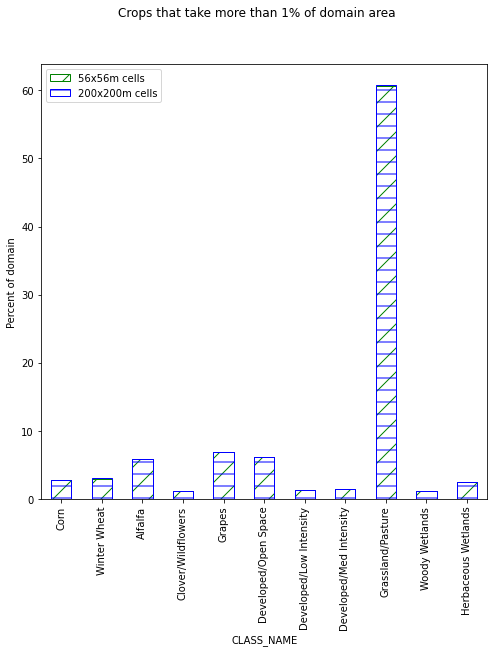

In [24]:
fig,ax = plt.subplots(figsize=(8,8))

print('The total cells originally: ', domain_dbf.crop_hist.sum(), 'The total cells after resampling: ', resampled_df.crop_hist.sum())

domain_dbf.loc[domain_dbf.crop_percent>1].plot(x='CLASS_NAME', y= 'crop_percent', 
                                               kind = 'bar', label = '56x56m cells', ax=ax, 
                                               edgecolor = 'green',fill = None, hatch = '/', alpha = 1)
plt.xlabel('Crop type')
plt.ylabel('Percent of domain')
plt.suptitle('Crops that take more than 1% of domain area')

resampled_df.loc[resampled_df.crop_percent>1].plot(x='CLASS_NAME', y= 'crop_percent',
                                                   kind = 'bar', label = '200x200m cells', ax=ax, 
                                                   edgecolor = 'blue', fill = None, hatch = '-',alpha =  1)
plt.savefig('Plots/crop_percents_before_after_nearest_resampling.png', dpi = 600, bbox_inches='tight')

print('% of 56mx56m domain covered by major crops (>1%): ', resampled_df.loc[resampled_df.crop_percent>1].crop_percent.sum())
print('% of 200mx200m domain covered by major crops (>1%): ', domain_dbf.loc[domain_dbf.crop_percent>1].crop_percent.sum())


In [ ]:
# set start and end date for range for the year to be iterated over
yr_strt = pd.to_datetime(str(y)+'-01-01')
yr_end = pd.to_datetime(str(y)+'-12-31')
if yr_strt < pd.to_datetime(strt_date):
    yr_strt = pd.to_datetime(strt_date)
if yr_end > pd.to_datetime(end_date):
    yr_end = pd.to_datetime(end_date)


# for each year, import the new crop raster and resample to the model grid
# and filter out the database of crops to match those in the domain
croprio, domain_dbf = crop_raster2array(crop_raster_list[file_num],crop_dbf_list[file_num], Kc)
file_num +=1

crop_data = croprio.resample_to_grid(modelgrid,
                            band=croprio.bands[0],
                            method="nearest")
# adjust domain_dbf to account for resampling
resampled_crops = np.append(np.unique(crop_data).astype(int),np.unique(crop_data)[-1])
resampled_hist =  np.histogram(crop_data, bins = resampled_crops)
# convert histogram to dataframe to join with domain database info for crops
resampled_hist = pd.DataFrame(np.transpose(np.vstack((resampled_hist[0], resampled_hist[1][:-1]))))
resampled_hist.columns =  ['crop_hist','VALUE']
resampled_hist.VALUE = resampled_hist.VALUE.astype(int)

resampled_df = resampled_hist.set_index('VALUE').join(domain_dbf.drop('crop_hist', axis=1).set_index('VALUE') , on = 'VALUE', how = 'inner')
resampled_df.crop_percent = 100*resampled_df.crop_hist/resampled_df.crop_hist.sum()
resampled_df['Kc'] = 0

# calculate the Kc date periods for each year
dates = calc_kc_dates(y, domain_dbf = resampled_df)

# find length of each year for referencing for the ET_final whole period to individual years
yearlen = len(pd.date_range(yr_strt, yr_end))
ETc = np.zeros((yearlen,nrow,ncol))

# calculate the ETc for the year and then save to a text file
#     ETc = ETc_calc(ET_final = ET_final[ET_index:ET_index+yearlen], dates=dates, domain_dbf= resampled_df)
#     ETc = ETc_calc(ET_final = monthly_ET_final[ET_index:ET_index+yearlen], dates=dates, domain_dbf= resampled_df)
# alternative ET data set that uses only data from fair oaks
ETc = ETc_calc(ET_final = ET_fo[ET_index:ET_index+yearlen], dates=dates, domain_dbf= resampled_df)

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

ax = croprio.plot(ax=ax)
ax.levels = domain_dbf.VALUE.values 

num_vals = len(domain_dbf.VALUE.values)
# bounds = domain_dbf.VALUE.values
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cbar = plt.colorbar(ax.images[0], ticks = domain_dbf.VALUE.values, values = domain_dbf.VALUE.values)
cbar.ax.set_yticklabels(domain_dbf.CLASS_NAME.values)  

# newcbar = np.zeros((num_vals,3))
# for i in np.arange(num_vals):
#     newcbar[i,:] = cbar.cmap.colors[domain_dbf.VALUE.values[i]]
# cbar.cmap.N = num_vals
# cbar.cmap.colors = newcbar 

ax.ticklabel_format(style='plain')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
# plt.savefig('Plots/Model_SFR_UZF_Progress/model_domain_crop_map.png', dpi = 300)

In [237]:

# crop_data = croprio.resample_to_grid(modelgrid,
#                                 band=croprio.bands[0],
#                                 method="nearest")

# # this is the same code accomplised by resample_to_grid taken directly from the flopy documentation because it was struggling
# # to reference scipy.interpolate.griddata
# crop_data = griddata( (croprio.xcenters.flatten(),croprio.ycenters.flatten()),
#          croprio.get_array(croprio.bands[0],masked=True).flatten(),
#          (modelgrid.xcellcenters.flatten(), modelgrid.ycellcenters.flatten()),
#          method="nearest")
# crop_data.shape = (100,230)